# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
df = pd.read_csv('../../../3_3_2_processed_data/modeling/df_cleaned_no_outliers.csv')

In [45]:
# Flip gap to be report on goal completion
df['overall_goal_completion'] = 100 - df['sr_DAILY_past24_gap']

# Rename goal reports to completion for clarity
df = df.rename(columns={
    'sr_DAILY_goal1_report': 'goal1_completion',
    'sr_DAILY_goal2_report': 'goal2_completion',
    'sr_DAILY_past24_values': 'values_adherence'
})

# Select gap feature

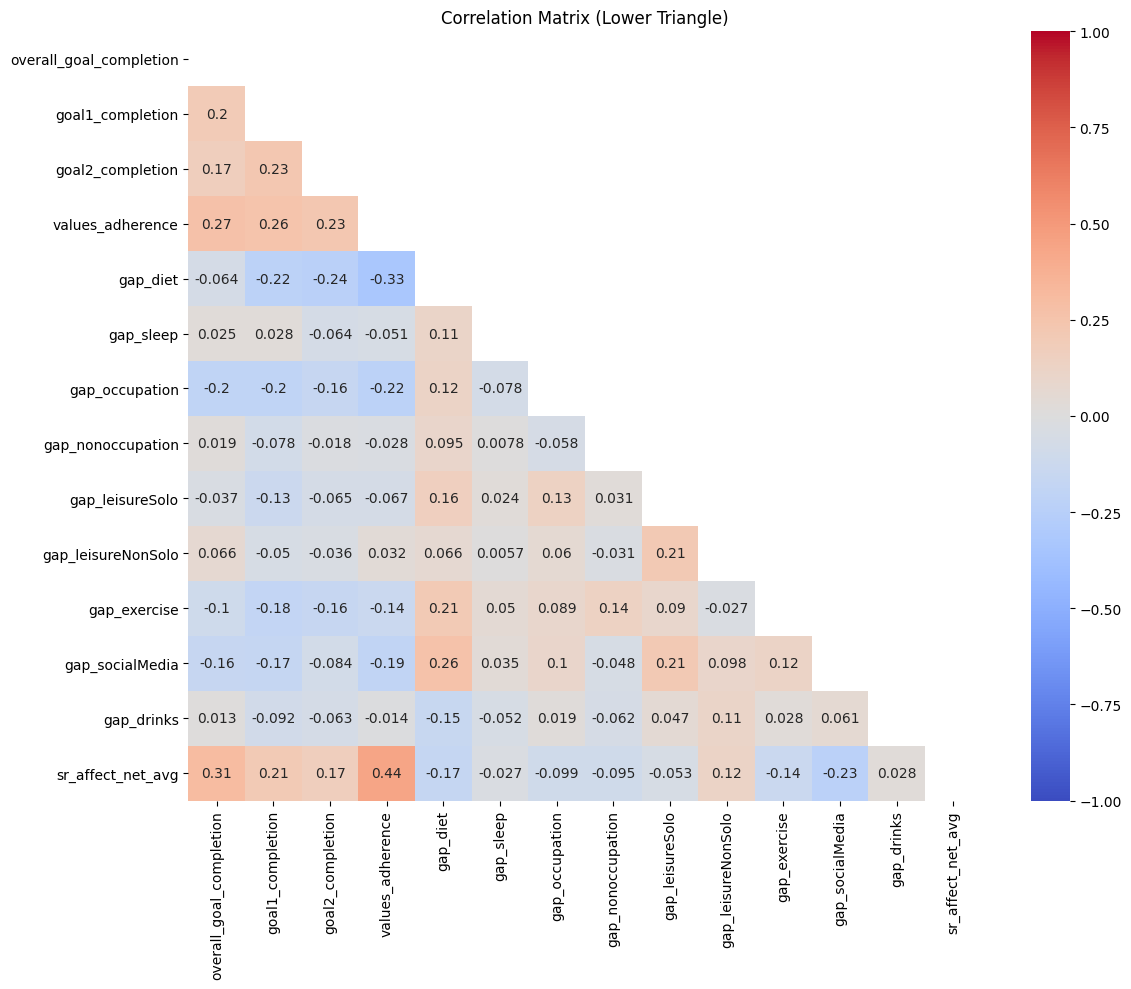

In [46]:
# Select columns for correlation matrix
cols = ['overall_goal_completion',
        'goal1_completion', 'goal2_completion',
        'values_adherence',
        'sr_DAILY_gap_diet',
        'sr_DAILY_gap_sleep', 
        'sr_DAILY_gap_occupation',
        'sr_DAILY_gap_nonoccupation',
        'sr_DAILY_gap_leisureSolo',
        'sr_DAILY_gap_leisureNonSolo',
        'sr_DAILY_gap_exercise',
        'sr_DAILY_gap_socialMedia',
        'sr_DAILY_gap_drinks',
        'sr_affect_net_avg']

# Create correlation matrix
corr = df[cols].corr()

# Get lower triangle only
mask = np.tril(np.ones_like(corr), k=-1).astype(bool)
corr_lower = corr.where(mask)

# Plot correlation matrix with renamed labels
plt.figure(figsize=(12,10))
renamed_labels = [col.replace('sr_DAILY_', '') for col in cols]
sns.heatmap(corr_lower, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            xticklabels=renamed_labels, yticklabels=renamed_labels)
plt.title('Correlation Matrix (Lower Triangle)')
plt.tight_layout()
plt.show()

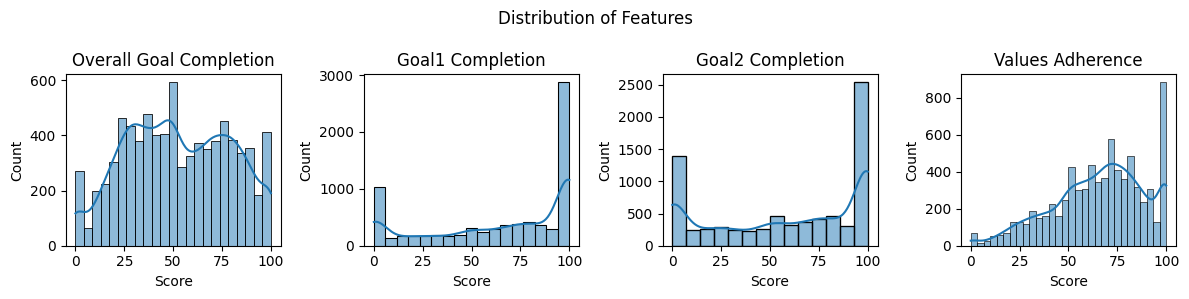

In [82]:
# Distribution of Outcome Measures

# Plot histograms with KDE for each measure
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle('Distribution of Features')

measures = ['overall_goal_completion', 'goal1_completion', 
           'goal2_completion', 'values_adherence']

for ax, measure in zip(axes, measures):
    sns.histplot(data=df, x=measure, kde=True, ax=ax)
    ax.set_title(measure.replace('_', ' ').title())
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


## Feature Weighting

### Simple Weighting

In [79]:
# Get correlations with affect
affect_corrs = df[['sr_affect_net_avg', 'overall_goal_completion', 
                   'goal1_completion', 'goal2_completion',
                   'values_adherence']].corr()['sr_affect_net_avg']

# Drop the correlation with itself
affect_corrs = affect_corrs.drop('sr_affect_net_avg')

# Take absolute values and normalize to sum to 1
weights = np.abs(affect_corrs)
weights = pd.DataFrame(weights / weights.sum()).reset_index()
weights.columns = ['measure', 'correlation']
weights = weights.sort_values('correlation', ascending=False)


print("Normalized weights:")
weights

Normalized weights:


,measure,correlation
3,values_adherence,0.393874
0,overall_goal_completion,0.273153
1,goal1_completion,0.182808
2,goal2_completion,0.150165


In [97]:
# Create weighted gap score using simple correlations
df['gap_simple'] = (
    df['overall_goal_completion'] * weights.loc[weights['measure'] == 'overall_goal_completion', 'correlation'].values[0] +
    df['goal1_completion'] * weights.loc[weights['measure'] == 'goal1_completion', 'correlation'].values[0] +
    df['goal2_completion'] * weights.loc[weights['measure'] == 'goal2_completion', 'correlation'].values[0] + 
    df['values_adherence'] * weights.loc[weights['measure'] == 'values_adherence', 'correlation'].values[0]
)

### Within PID Correlation Averaged

In [104]:
# Create empty lists to store correlations
correlations = []
pids = []
measures = []

# Get list of measures
gap_measures = ['overall_goal_completion', 'goal1_completion', 
                'goal2_completion', 'values_adherence']

# Calculate correlations for each PID and measure
for pid in df.PID.unique():
    pid_data = df[df.PID == pid]
    
    # Calculate correlation for each measure
    for measure in gap_measures:
        corr = pid_data[measure].corr(pid_data['sr_affect_net_avg'])
        correlations.append(corr)
        pids.append(pid)
        measures.append(measure)

# Create DataFrame with results        
corr_df = pd.DataFrame({
    'PID': pids,
    'measure': measures, 
    'correlation': correlations
})

# Calculate mean correlation for each measure
mean_corrs = pd.DataFrame(corr_df.groupby('measure')['correlation'].mean()).reset_index()
# Sort by correlation value
mean_corrs = mean_corrs.sort_values('correlation', ascending=False)

print("\nMean correlations by measure:")
mean_corrs

# # Calculate standard error for each measure
# se_corrs = corr_df.groupby('measure')['correlation'].sem()
# print("\nStandard errors by measure:")
# print(se_corrs)

# # Reshape to wide format for hierarchical analysis
# corr_wide = corr_df.pivot(index='PID', columns='measure', values='correlation')

# # Calculate correlations between measures
# measure_correlations = corr_wide.corr()
# print("\nCorrelations between measures:")
# print(measure_correlations)


Mean correlations by measure:


,measure,correlation
3,values_adherence,0.286359
2,overall_goal_completion,0.163043
0,goal1_completion,0.122002
1,goal2_completion,0.085401


In [105]:
# Take absolute values and normalize to sum to 1
mean_corrs['correlation'] = np.abs(mean_corrs['correlation'])
mean_corrs['correlation'] = mean_corrs['correlation'] / mean_corrs['correlation'].sum()
# Rename correlation column to weights
mean_corrs = mean_corrs.rename(columns={'correlation': 'weights'})

print('Normalized weights:')
mean_corrs

Normalized weights:


,measure,weights
3,values_adherence,0.435988
2,overall_goal_completion,0.248236
0,goal1_completion,0.185751
1,goal2_completion,0.130025


In [107]:
# Create weighted gap score using subject avg correlations
df['gap_pidAvg'] = (
    df['overall_goal_completion'] * mean_corrs.loc[mean_corrs['measure'] == 'overall_goal_completion', 'weights'].values[0] +
    df['goal1_completion'] * mean_corrs.loc[mean_corrs['measure'] == 'goal1_completion', 'weights'].values[0] +
    df['goal2_completion'] * mean_corrs.loc[mean_corrs['measure'] == 'goal2_completion', 'weights'].values[0] + 
    df['values_adherence'] * mean_corrs.loc[mean_corrs['measure'] == 'values_adherence', 'weights'].values[0]
)

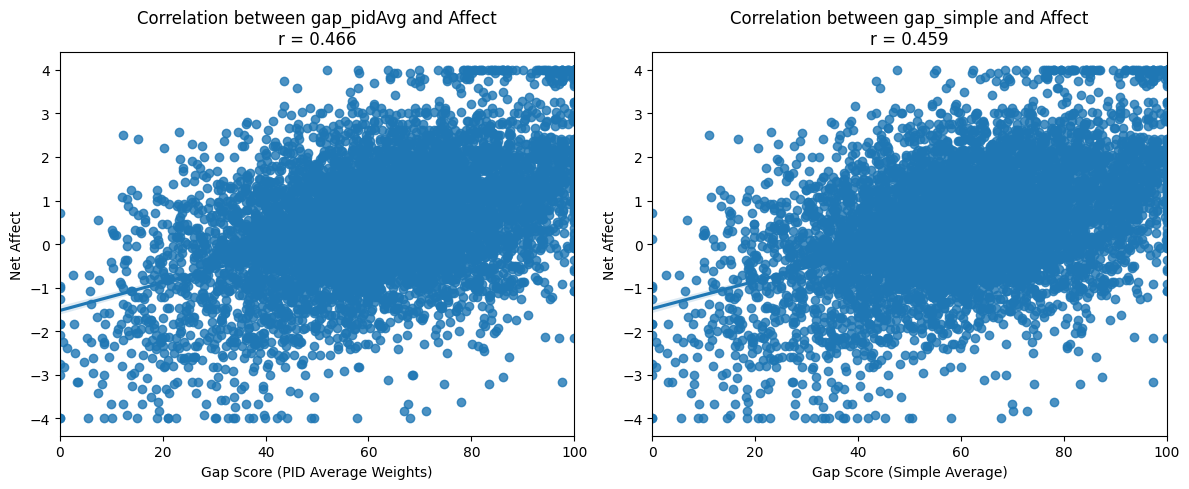

In [108]:
# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot gap_pidAvg correlation
sns.regplot(data=df, x='gap_pidAvg', y='sr_affect_net_avg', ax=ax1)
ax1.set_title(f'Correlation between gap_pidAvg and Affect\nr = {df["gap_pidAvg"].corr(df["sr_affect_net_avg"]):.3f}')
ax1.set_xlabel('Gap Score (PID Average Weights)')
ax1.set_ylabel('Net Affect')

# Plot gap_simple correlation 
sns.regplot(data=df, x='gap_simple', y='sr_affect_net_avg', ax=ax2)
ax2.set_title(f'Correlation between gap_simple and Affect\nr = {df["gap_simple"].corr(df["sr_affect_net_avg"]):.3f}')
ax2.set_xlabel('Gap Score (Simple Average)')
ax2.set_ylabel('Net Affect')

plt.tight_layout()
plt.show()

### MLM Version

Model with random intercepts (not converging with random slopes)

In [149]:
predictors = ['values_adherence', 'overall_goal_completion', 'goal1_completion', 'goal2_completion']
target = 'sr_affect_net_avg'
random_intercepts = True

# Prepare training data
train_data_clean = df[predictors + [target, 'PID']].dropna()

# Normalize each feature column within each participant
for predictor in predictors:
    train_data_clean[predictor] = train_data_clean.groupby('PID')[predictor].transform(lambda x: (x - x.mean()) / x.std())

# Remove any NaN values that were introduced by normalization
train_data_clean = train_data_clean.dropna()

# Create formula string with all predictors
predictor_formula = ' + '.join(predictors)

# Fit model based on random_intercepts parameter
if random_intercepts:
    md = smf.mixedlm(f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"1 + {predictor_formula}") #  + {predictor_formula}
else:
    md = smf.mixedlm(f"{target} ~ 1 + {predictor_formula}",
                        train_data_clean,
                        groups=train_data_clean["PID"],
                        re_formula=f"0 + {predictor_formula}")

# Try fitting with different optimizer settings
try:
    # First attempt with nm optimizer and increased iterations
    model = md.fit(method='nm', maxiter=3000)
except:
    try:
        # Second attempt with BFGS optimizer and increased iterations
        model = md.fit(method='bfgs', maxiter=3000)
    except:
        # Final attempt with L-BFGS-B optimizer
        model = md.fit(method='lbfgs', maxiter=3000)

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



In [150]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                      MixedLM         Dependent Variable:         sr_affect_net_avg
No. Observations:           7558            Method:                     REML             
No. Groups:                 105             Scale:                      0.5516           
Min. group size:            37              Log-Likelihood:             -8919.7538       
Max. group size:            84              Converged:                  Yes              
Mean group size:            72.0                                                         
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.435    0.096  4.524 0.000  0.247  0.624
values_adherence                                0.210    0.021 10.187 0.000  0.170  0.250
overall_goal_completion                         0.100    0.015  6.576 0.000  0.070  0.130
goal1_completion                                0.051    0.012  4.295 0.000  0.028  0.075
goal2_completion                                0.025    0.010  2.499 0.012  0.005  0.045
Group Var                                       0.964    0.185                           
Group x values_adherence Cov                    0.001    0.028                           
values_adherence Var                            0.035    0.009                           
Group x overall_goal_completion Cov            -0.011    0.021                           
values_adherence x overall_goal_completion Cov  0.001    0.005                           
overall_goal_completion Var                     0.015    0.005                           
Group x goal1_completion Cov                    0.003    0.018                           
values_adherence x goal1_completion Cov         0.004    0.004                           
overall_goal_completion x goal1_completion Cov -0.000    0.003                           
goal1_completion Var                            0.006    0.004                           
Group x goal2_completion Cov                   -0.018    0.015                           
values_adherence x goal2_completion Cov        -0.000    0.003                           
overall_goal_completion x goal2_completion Cov  0.002    0.003                           
goal1_completion x goal2_completion Cov         0.000    0.003                           
goal2_completion Var                            0.002    0.003                           
=========================================================================================

"""

In [131]:
# Extract coefficients for predictors
predictor_coefs = model.fe_params[1:] # Skip intercept
predictor_coefs = pd.Series(predictor_coefs, index=predictors)

# Rename columns to match expected names for later code
normalized_coefs_df = pd.DataFrame(normalized_coefs).reset_index()
normalized_coefs_df.columns = ['measure', 'weights']
normalized_coefs_df

,measure,weights
0,values_adherence,0.530248
1,overall_goal_completion,0.249118
2,goal1_completion,0.146432
3,goal2_completion,0.074202


In [132]:
# Create weighted gap score using simple correlations
df['gap_mlm_io_coef'] = (
    df['overall_goal_completion'] * normalized_coefs_df.loc[normalized_coefs_df['measure'] == 'overall_goal_completion', 'weights'].values[0] +
    df['goal1_completion'] * normalized_coefs_df.loc[normalized_coefs_df['measure'] == 'goal1_completion', 'weights'].values[0] +
    df['goal2_completion'] * normalized_coefs_df.loc[normalized_coefs_df['measure'] == 'goal2_completion', 'weights'].values[0] + 
    df['values_adherence'] * normalized_coefs_df.loc[normalized_coefs_df['measure'] == 'values_adherence', 'weights'].values[0]
)

In [134]:
# Calculate correlation between gap_mlm_io_coef and sr_affect_net_avg
gap_mlm_io_coef_corr = df['gap_mlm_io_coef'].corr(df['sr_affect_net_avg'])
print(f"Correlation between gap_mlm_io_coef and sr_affect_net_avg: {gap_mlm_io_coef_corr:.3f}")


Correlation between gap_mlm_io_coef and sr_affect_net_avg: 0.484


In [138]:
# Extract z for predictors
predictor_zs = model.tvalues[1:] # Skip intercept
predictor_zs = pd.Series(predictor_zs, index=predictors)

# Normalize z-scores to sum to 1
normalized_zs = predictor_zs / predictor_zs.sum()

# Rename columns to match expected names for later code
normalized_zs_df = pd.DataFrame(normalized_zs).reset_index()
normalized_zs_df.columns = ['measure', 'weights']
normalized_zs_df

,measure,weights
0,values_adherence,0.529425
1,overall_goal_completion,0.250069
2,goal1_completion,0.146011
3,goal2_completion,0.074495


In [141]:
# Create weighted gap score using simple correlations
df['gap_mlm_io_z'] = (
    df['overall_goal_completion'] * normalized_zs_df.loc[normalized_zs_df['measure'] == 'overall_goal_completion', 'weights'].values[0] +
    df['goal1_completion'] * normalized_zs_df.loc[normalized_zs_df['measure'] == 'goal1_completion', 'weights'].values[0] +
    df['goal2_completion'] * normalized_zs_df.loc[normalized_zs_df['measure'] == 'goal2_completion', 'weights'].values[0] + 
    df['values_adherence'] * normalized_zs_df.loc[normalized_zs_df['measure'] == 'values_adherence', 'weights'].values[0]
)

In [142]:
# Calculate correlation between gap_mlm_io_z and sr_affect_net_avg
gap_mlm_io_z_corr = df['gap_mlm_io_z'].corr(df['sr_affect_net_avg'])
print(f"Correlation between gap_mlm_io_z and sr_affect_net_avg: {gap_mlm_io_z_corr:.3f}")

Correlation between gap_mlm_io_z and sr_affect_net_avg: 0.484


## Distribution of correlations

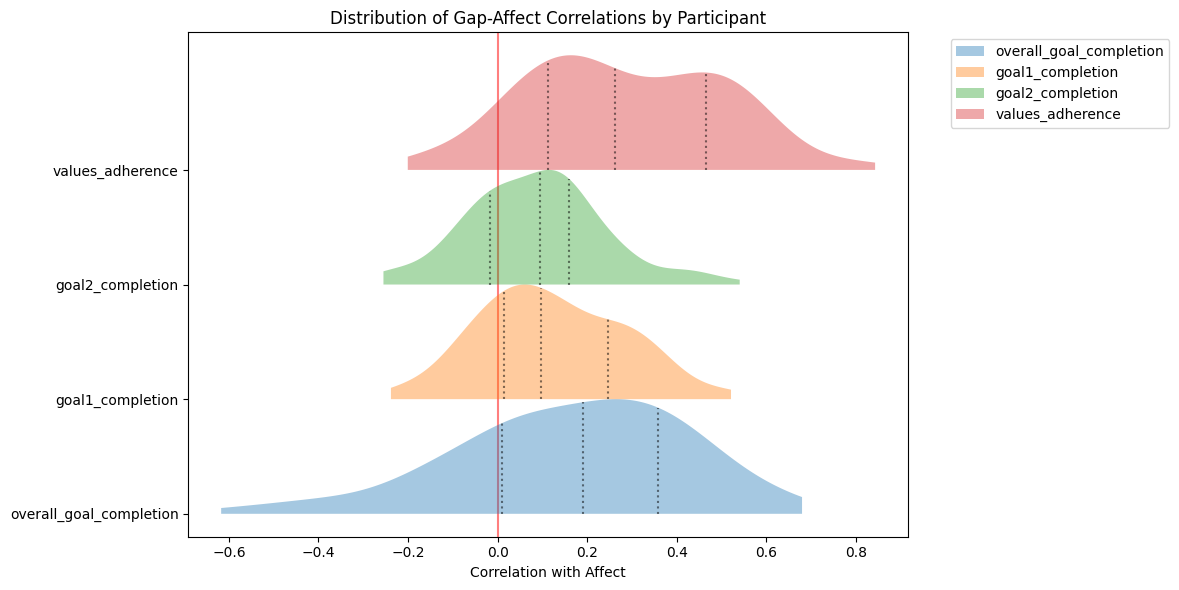

In [48]:
# Get list of gap columns
gap_cols = ['overall_goal_completion',
            'goal1_completion', 'goal2_completion',
            'values_adherence']

# Calculate correlations by PID
correlations = []
for pid in df.PID.unique():
    pid_data = df[df.PID == pid]
    for col in gap_cols:
        corr = pid_data[col].corr(pid_data['sr_affect_net_avg'])
        correlations.append({
            'PID': pid,
            'gap_measure': col,
            'correlation': corr
        })

# Convert to dataframe
corr_df = pd.DataFrame(correlations)

# Create ridgeline plot
plt.figure(figsize=(12, 6))

# Add vertical line at 0
plt.axvline(x=0, color='red', linestyle='-', alpha=0.5, zorder=0)

for idx, gap_measure in enumerate(gap_cols):
    data = corr_df[corr_df['gap_measure'] == gap_measure]['correlation']
    kernel = stats.gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 200)
    plt.fill_between(x_range, 
                     idx + kernel(x_range)/kernel(x_range).max(),
                     idx,
                     alpha=0.4,
                     label=gap_measure)
    
    # Add quantile lines
    quantiles = np.quantile(data, [0.25, 0.5, 0.75])
    for q in quantiles:
        kernel_height = kernel(q)/kernel(x_range).max()
        plt.vlines(q, idx, idx + kernel_height, 
                  colors='black', linestyles=':', alpha=0.5)

plt.xlabel('Correlation with Affect')
plt.yticks(range(len(gap_cols)), gap_cols)
plt.title('Distribution of Gap-Affect Correlations by Participant')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [57]:
# Create PID correlation DF

# Create empty list to store correlations
correlations_by_pid = []

# Variables to correlate with affect
variables = ['overall_goal_completion', 'goal1_completion', 
            'goal2_completion', 'values_adherence']

# Calculate correlations for each PID
for i, pid in enumerate(df['PID'].unique(), 1):
    pid_data = df[df['PID'] == pid]
    
    # Calculate correlations
    corr_values = {}
    corr_values['subject'] = i
    corr_values['obvs'] = len(pid_data.dropna(subset=['sr_affect_net_avg'] + [var for var in variables if var in pid_data.columns]))  # Count rows with no missing values
    
    for var in variables:
        if var in pid_data.columns:  # Check if variable exists
            corr = pid_data['sr_affect_net_avg'].corr(pid_data[var])
            corr_values[f'{var}_corr'] = corr
        else:
            corr_values[f'{var}_corr'] = np.nan
            
    correlations_by_pid.append(corr_values)

# Convert to dataframe
pid_correlations_df = pd.DataFrame(correlations_by_pid)

# Display the dataframe
pid_correlations_df.head()

,subject,obvs,overall_goal_completion_corr,goal1_completion_corr,goal2_completion_corr,values_adherence_corr
0,1,82,0.240779,0.145790,0.090500,0.599799
1,2,77,0.283964,-0.112379,-0.022704,-0.132553
2,3,52,0.679866,0.362378,0.372508,0.788393
3,4,72,0.058387,0.033800,0.001565,0.113378
4,5,53,0.240803,0.036526,-0.009367,0.167808


## 4 Feature Clustering

### 2 Clusters

In [58]:
# Get correlation columns for clustering
cluster_columns = [col for col in pid_correlations_df.columns if '_corr' in col]
X = pid_correlations_df[cluster_columns]

# Perform k-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster assignments to dataframe
pid_correlations_df['cluster'] = clusters

# Calculate mean correlations and size for each cluster
cluster_means = pid_correlations_df.groupby('cluster').agg({
    **{col: 'mean' for col in cluster_columns},
    'subject': 'count',  # Count number of PIDs per cluster
    'obvs': 'mean'  # Average observations per cluster
}).rename(columns={
    'subject': 'n_subjects',
    'obvs': 'avg_obvs'
})

# Visualize using PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create interactive 3D scatter plot
import plotly.express as px
import plotly.graph_objects as go

# Create DataFrame for plotting
plot_df = pd.DataFrame(
    X_pca, 
    columns=['PC1', 'PC2', 'PC3']
)
plot_df['Cluster'] = clusters
plot_df['Subject'] = pid_correlations_df['subject']

# Create scatter plot
fig = px.scatter_3d(
    plot_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='Subject Clusters Based on Correlation Patterns (3D)',
    labels={'PC1': 'First Principal Component',
            'PC2': 'Second Principal Component',
            'PC3': 'Third Principal Component'}
)

# Add feature vectors
for i, col in enumerate(cluster_columns):
    # Scale the vectors for visibility
    scale = 2
    fig.add_trace(go.Scatter3d(
        x=[0, pca.components_[0, i] * scale],
        y=[0, pca.components_[1, i] * scale],
        z=[0, pca.components_[2, i] * scale],
        mode='lines+text',
        line=dict(color='gray', width=2),
        text=['', col.replace('sr_DAILY_', '').replace('_corr', '')],
        name=col.replace('sr_DAILY_', '').replace('_corr', '')
    ))

# Update layout
fig.update_traces(
    marker=dict(size=3),
)
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    showlegend=False
)

fig.show()

cluster_means

,overall_goal_completion_corr,goal1_completion_corr,goal2_completion_corr,values_adherence_corr,n_subjects,avg_obvs
cluster,,,,,,
0,0.046625,0.071372,0.058916,0.185958,70,71.928571
1,0.395878,0.223262,0.138370,0.487163,35,72.085714


### 3 Clusters

In [59]:
# Get correlation columns for clustering
cluster_columns = [col for col in pid_correlations_df.columns if '_corr' in col]
X = pid_correlations_df[cluster_columns]

# Perform k-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster assignments to dataframe
pid_correlations_df['cluster'] = clusters

# Calculate mean correlations and size for each cluster
cluster_means = pid_correlations_df.groupby('cluster').agg({
    **{col: 'mean' for col in cluster_columns},
    'subject': 'count',  # Count number of PIDs per cluster
    'obvs': 'mean'  # Average number of observations per cluster
}).rename(columns={
    'subject': 'n_subjects',
    'obvs': 'avg_obvs'
})

# Visualize using PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create interactive 3D scatter plot
import plotly.express as px
import plotly.graph_objects as go

# Create DataFrame for plotting
plot_df = pd.DataFrame(
    X_pca, 
    columns=['PC1', 'PC2', 'PC3']
)
plot_df['Cluster'] = clusters
plot_df['Subject'] = pid_correlations_df['subject']

# Create scatter plot
fig = px.scatter_3d(
    plot_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='Subject Clusters Based on Correlation Patterns (3D)',
    labels={'PC1': 'First Principal Component',
            'PC2': 'Second Principal Component',
            'PC3': 'Third Principal Component'}
)

# Add feature vectors
for i, col in enumerate(cluster_columns):
    # Scale the vectors for visibility
    scale = 2
    fig.add_trace(go.Scatter3d(
        x=[0, pca.components_[0, i] * scale],
        y=[0, pca.components_[1, i] * scale],
        z=[0, pca.components_[2, i] * scale],
        mode='lines+text',
        line=dict(color='gray', width=2),
        text=['', col.replace('sr_DAILY_', '').replace('_corr', '')],
        name=col.replace('sr_DAILY_', '').replace('_corr', '')
    ))

# Update layout
fig.update_traces(
    marker=dict(size=3),
)
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    showlegend=False
)

fig.show()

cluster_means

,overall_goal_completion_corr,goal1_completion_corr,goal2_completion_corr,values_adherence_corr,n_subjects,avg_obvs
cluster,,,,,,
0,-0.119782,0.099843,0.068867,0.263547,35,72.457143
1,0.411630,0.237636,0.145419,0.528594,29,72.103448
2,0.228649,0.059129,0.057063,0.134497,41,71.487805


## 3 Feature Clustering

Without Values feature 👇

### 2 Clusters

In [52]:
# Get first 3 correlation columns
cluster_cols = [col for col in pid_correlations_df.columns if '_corr' in col][:3]
cluster_data = pid_correlations_df[cluster_cols]

# Perform k-means clustering with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(cluster_data)

# Create 3D scatter plot
fig = px.scatter_3d(
    data_frame=pid_correlations_df,
    x=cluster_cols[0],
    y=cluster_cols[1], 
    z=cluster_cols[2],
    color=clusters,
    title='Subject Clusters Based on First 3 Correlation Values',
    labels={
        cluster_cols[0]: cluster_cols[0].replace('sr_DAILY_', '').replace('_corr', ''),
        cluster_cols[1]: cluster_cols[1].replace('sr_DAILY_', '').replace('_corr', ''),
        cluster_cols[2]: cluster_cols[2].replace('sr_DAILY_', '').replace('_corr', '')
    }
)

# Update marker size and layout
fig.update_traces(marker=dict(size=3))
fig.update_layout(
    scene=dict(
        xaxis_title=cluster_cols[0].replace('sr_DAILY_', '').replace('_corr', ''),
        yaxis_title=cluster_cols[1].replace('sr_DAILY_', '').replace('_corr', ''),
        zaxis_title=cluster_cols[2].replace('sr_DAILY_', '').replace('_corr', '')
    ),
    showlegend=True
)

fig.show()

# Print average correlations and size for each cluster
print("\nAverage correlations by cluster:")
for cluster in [0, 1]:
    print(f"\nCluster {cluster}:")
    cluster_mask = clusters == cluster
    print(f"Number of subjects: {sum(cluster_mask)}")
    for col in cluster_cols:
        col_name = col.replace('sr_DAILY_', '').replace('_corr', '')
        avg_corr = pid_correlations_df[col][cluster_mask].mean()
        print(f"{col_name}: {avg_corr:.3f}")


Average correlations by cluster:

Cluster 0:
Number of subjects: 44
overall_goal_completion: -0.079
goal1_completion: 0.065
goal2_completion: 0.037

Cluster 1:
Number of subjects: 61
overall_goal_completion: 0.338
goal1_completion: 0.163
goal2_completion: 0.121


### 3 Clusters

In [53]:
# Get first 3 correlation columns
cluster_cols = [col for col in pid_correlations_df.columns if '_corr' in col][:3]
cluster_data = pid_correlations_df[cluster_cols]

# Perform k-means clustering with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(cluster_data)

# Create 3D scatter plot
fig = px.scatter_3d(
    data_frame=pid_correlations_df,
    x=cluster_cols[0],
    y=cluster_cols[1], 
    z=cluster_cols[2],
    color=clusters,
    title='Subject Clusters Based on First 3 Correlation Values',
    labels={
        cluster_cols[0]: cluster_cols[0].replace('sr_DAILY_', '').replace('_corr', ''),
        cluster_cols[1]: cluster_cols[1].replace('sr_DAILY_', '').replace('_corr', ''),
        cluster_cols[2]: cluster_cols[2].replace('sr_DAILY_', '').replace('_corr', '')
    }
)

# Update marker size and layout
fig.update_traces(marker=dict(size=3))
fig.update_layout(
    scene=dict(
        xaxis_title=cluster_cols[0].replace('sr_DAILY_', '').replace('_corr', ''),
        yaxis_title=cluster_cols[1].replace('sr_DAILY_', '').replace('_corr', ''),
        zaxis_title=cluster_cols[2].replace('sr_DAILY_', '').replace('_corr', '')
    ),
    showlegend=True
)

fig.show()

# Print average correlations and size for each cluster
print("\nAverage correlations by cluster:")
for cluster in [0, 1, 2]:
    print(f"\nCluster {cluster}:")
    cluster_mask = clusters == cluster
    print(f"Number of subjects: {sum(cluster_mask)}")
    for col in cluster_cols:
        col_name = col.replace('sr_DAILY_', '').replace('_corr', '')
        avg_corr = pid_correlations_df[col][cluster_mask].mean()
        print(f"{col_name}: {avg_corr:.3f}")


Average correlations by cluster:

Cluster 0:
Number of subjects: 27
overall_goal_completion: -0.176
goal1_completion: 0.100
goal2_completion: 0.058

Cluster 1:
Number of subjects: 32
overall_goal_completion: 0.405
goal1_completion: 0.274
goal2_completion: 0.161

Cluster 2:
Number of subjects: 46
overall_goal_completion: 0.193
goal1_completion: 0.030
goal2_completion: 0.049
